# Breadth First Search

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using breadth first search


__function__ BREADTH-FIRST-SEARCH(graph) __returns__ a route and cost, or failure  
&emsp;__if__ problem's initial state is a goal __then return__ empty path to initial state  
&emsp;_frontier_ &larr; a FIFO queue initially containing one path, for the _problem_'s initial state  
&emsp;_reached_ &larr; a set of states; initially empty  
&emsp;_solution_ &larr; failure  
&emsp;__while__  _frontier_ is not empty __do__  
&emsp;&emsp;&emsp;_parent_ &larr; the first node in _frontier_  
&emsp;&emsp;&emsp;__for__ _child_ __in__ successors(_parent_) __do__   
&emsp;&emsp;&emsp;&emsp;&emsp;_s_ &larr; _child_.state  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _s_ is a goal  __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__return__  _child_  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _s_ is not in _reached_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;add _s_ to _reached_  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;add _child_ to the end of _frontier_  
&emsp;__return__  _solution_

In [1]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;

# you HAVE to upload a number of files and folders used in the code
# problem.py - utils.py - data files inside directory named data
# upload them in the home directory --- don't go into any folder, just press upload button
# and choose these files and folders
# so tthe directory should be 
#|- data/       |- graph.html
#|              |- route.html 
#|- sample_data/ 
#|- problem.py
#|- utils.py

In [15]:
import osmnx as ox
import networkx as nx
from IPython.display import IFrame, HTML
from collections import deque
import matplotlib.pyplot as plt
from problem import *
from utils import *

Here OSMnx find the largest connected component centered around the ```location point``` with specified ```dist``` on each side (w/n/e/s).

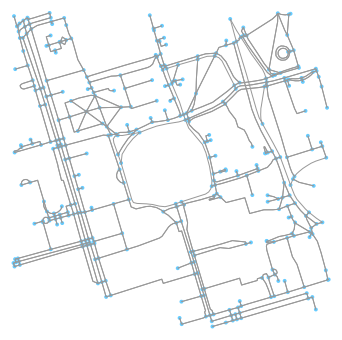

In [16]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

In [17]:
# we need to save the graph 
filepath = 'data/graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

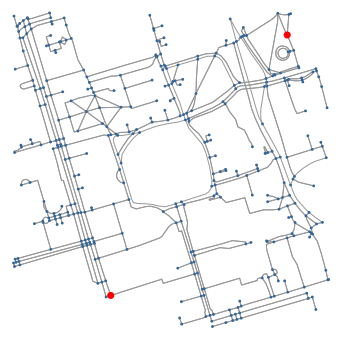

In [18]:
# marking both the source and destination node

nc = ['r' if node == 389677909 or node == 55808290 else '#336699' for node in G.nodes()]
ns = [50 if node == 389677909 or node == 55808290 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

Each node in our graph is represented as a dictionary so manipulating them would obfuscate the algorithm manipulating them and would be unnecessary expensive computationally <b>so</b> we define class ```Node``` only retains the data we need to be able to do searching and traversing.

Please check its source code in ```./problem.py``` to know how it capture the data from the graph

In [19]:
%%capture
source(Node)

# The Algorithm

In [20]:
# first define the origin/source nodes as Node
origin = Node(graph = G, node = G[55808290], osmid = 55808290, distance = 0, parent = None)
destination = Node(graph = G, node = G[389677909], osmid = 389677909)

In [30]:
bar = tqdm(total=len(G))
route = []
import time
frontier = deque([origin])
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    node = frontier.popleft()
    explored.add(node)
    if node == destination:
        route, cost = node.path()
        found = True
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                found = True
            frontier.append(child)

bar.close()



  0%|          | 0/375 [00:00<?, ?it/s]

  1%|          | 2/375 [00:00<00:18, 19.70it/s]

  1%|          | 3/375 [00:00<00:25, 14.68it/s]

  1%|          | 4/375 [00:00<00:29, 12.60it/s]

  1%|▏         | 5/375 [00:00<00:32, 11.44it/s]

  2%|▏         | 6/375 [00:00<00:34, 10.75it/s]

  2%|▏         | 7/375 [00:00<00:35, 10.28it/s]

  2%|▏         | 8/375 [00:00<00:36,  9.98it/s]

  2%|▏         | 9/375 [00:00<00:37,  9.77it/s]

  3%|▎         | 10/375 [00:00<00:37,  9.61it/s]

  3%|▎         | 11/375 [00:01<00:38,  9.49it/s]

  3%|▎         | 12/375 [00:01<00:38,  9.39it/s]

  3%|▎         | 13/375 [00:01<00:38,  9.41it/s]

  4%|▎         | 14/375 [00:01<00:38,  9.35it/s]

  4%|▍         | 15/375 [00:01<00:38,  9.39it/s]

  4%|▍         | 16/375 [00:01<00:38,  9.31it/s]

  5%|▍         | 17/375 [00:01<00:38,  9.34it/s]

  5%|▍         | 18/375 [00:01<00:38,  9.32it/s]

  5%|▌         | 19/375 [00:01<00:38,  9.28it/s]

  5%|▌         | 20/375 [00:02<00:38,  9.31it/s]

  6%|▌         

 39%|███▉      | 146/375 [00:15<00:24,  9.44it/s]

 39%|███▉      | 147/375 [00:15<00:24,  9.35it/s]

 39%|███▉      | 148/375 [00:15<00:23,  9.47it/s]

 40%|███▉      | 149/375 [00:15<00:24,  9.40it/s]

 40%|████      | 150/375 [00:15<00:24,  9.34it/s]

 40%|████      | 151/375 [00:16<00:23,  9.34it/s]

 41%|████      | 152/375 [00:16<00:23,  9.41it/s]

 41%|████      | 153/375 [00:16<00:23,  9.39it/s]

 41%|████      | 154/375 [00:16<00:23,  9.39it/s]

 41%|████▏     | 155/375 [00:16<00:23,  9.27it/s]

 42%|████▏     | 156/375 [00:16<00:23,  9.28it/s]

 42%|████▏     | 157/375 [00:16<00:23,  9.23it/s]

 42%|████▏     | 158/375 [00:16<00:23,  9.22it/s]

 42%|████▏     | 159/375 [00:16<00:23,  9.25it/s]

 43%|████▎     | 160/375 [00:17<00:23,  9.24it/s]

 43%|████▎     | 161/375 [00:17<00:23,  9.21it/s]

 43%|████▎     | 162/375 [00:17<00:23,  9.20it/s]

 43%|████▎     | 163/375 [00:17<00:22,  9.27it/s]

 44%|████▎     | 164/375 [00:17<00:22,  9.24it/s]

 44%|████▍     | 165/375 [00:17

let's see the length of that route

In [8]:
cost

954.5749999999999

let's visualize the route on the graph

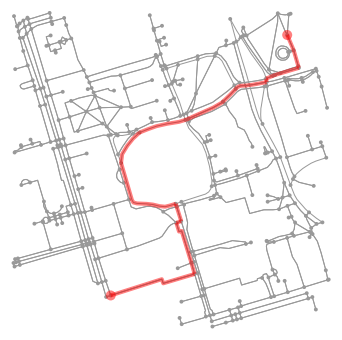

In [12]:
fig, ax = ox.plot_graph_route(G, route)

In [13]:
route_map = ox.plot_route_folium(G, route)
filepath = 'data/route.html'
route_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [4]:
from tqdm import tqdm

In [5]:
l = [1 for i in range(10000)]

In [6]:
l

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
